<a href="https://colab.research.google.com/github/VienneseWaltz/Churn-rate-at-Robinhood/blob/main/customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load packages


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE


In [2]:
from google.colab import files
import io

# uploaded = files.upload()

# Reading in the equity_value_data.csv
# equity_df = pd.read_csv(io.BytesIO(uploaded['equity_value_data.csv']))
# equity_df = pd.read_csv('equity_value_data.csv')
equity_df = pd.read_csv('/content/equity_value_data.csv')


# New Section

In [3]:
# Find how many rows and columns are there in the equity_df
print(equity_df.shape, '\n')

(50989, 3) 



In [4]:
# Return the first 5 rows of the equity_df
equity_df.head()

,timestamp,close_equity,user_id
0,2016-11-16T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
1,2016-11-17T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
2,2016-11-18T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
3,2016-11-21T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
4,2016-11-22T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03


In [5]:
# Count NaN values in the equity_df
equity_df.isna().sum()

# Convert the equity_df to a pandas datetime object, and then return the
# number of unique time-stamps, close_equity values and user_ids in equity_df.

# NaT or missing values would be flagged when one uses the errors='coerce'
equity_df.timestamp = pd.to_datetime(equity_df.timestamp, errors = 'coerce')
equity_df.nunique()


timestamp         254
close_equity    43204
user_id           245
dtype: int64

In [6]:
# Determine the missing days (gap_days) from equity_value_data.csv.

# First group based on 'user_id' and determine, using timestamp.diff() to find the missing days(gap_days)
# from equity_value_data.csv
equity_df['gap_days'] = equity_df.groupby(['user_id']).timestamp.diff()
# equity_df['gap_days'] = equity_df.timestamp.diff()
# Display to see how equity_df looks from rows 160 to 169
equity_df.iloc[160:170]


,timestamp,close_equity,user_id,gap_days
160,2017-07-10 00:00:00+00:00,4169.9100,bcef4fa9b0bdf22bcf7deae708decf03,3 days
161,2017-07-11 00:00:00+00:00,4169.9100,bcef4fa9b0bdf22bcf7deae708decf03,1 days
162,2017-07-12 00:00:00+00:00,4169.9100,bcef4fa9b0bdf22bcf7deae708decf03,1 days
163,2016-11-11 00:00:00+00:00,41.1802,1872e03edd5a15905503cfbb8ea31545,NaT
164,2016-11-14 00:00:00+00:00,39.2800,1872e03edd5a15905503cfbb8ea31545,3 days
165,2016-11-15 00:00:00+00:00,41.9000,1872e03edd5a15905503cfbb8ea31545,1 days
166,2016-11-17 00:00:00+00:00,203.6000,1872e03edd5a15905503cfbb8ea31545,2 days
167,2016-11-18 00:00:00+00:00,194.3700,1872e03edd5a15905503cfbb8ea31545,1 days
168,2016-11-21 00:00:00+00:00,193.7660,1872e03edd5a15905503cfbb8ea31545,3 days
169,2016-11-22 00:00:00+00:00,187.6704,1872e03edd5a15905503cfbb8ea31545,1 days


In [7]:
# Find out the number of users who have churned, we count the number of users
# who have a time gap of 28 days or more

# Returns the number of unique churned users i.e. users who have not logged on for 28 days or more
num_churned_users = equity_df[equity_df['gap_days'] >= pd.Timedelta('28 days')]['user_id'].nunique()

# Returns the number of unique churned user_ids (in the 'user_id' column) in an array
churned_user_ids = equity_df[equity_df['gap_days'] >= pd.Timedelta('28 days')]['user_id'].unique()

print(f'Number of unique churned user_ids =', len(churned_user_ids))

# Find out the total number of unique user_ids as that would give us the denominator we need
total_unique_user_ids = equity_df['user_id'].unique()
print(f'Total number of unique user_ids in equity_df =', len(total_unique_user_ids))

# Percentage of churned users = ((num_churned_users) / len(total_unique_user_ids)) * 100
percent_of_churned_users = np.round( (num_churned_users)/len(total_unique_user_ids) * 100, decimals = 2)
print('The percentage of churned users = {0}%'.format(percent_of_churned_users))

Number of unique churned user_ids = 16
Total number of unique user_ids in equity_df = 246
The percentage of churned users = 6.5%


In [8]:
###################################################################################
# Part B - Building a Classifier
###################################################################################
# Reading in the features_data.csv

In [9]:
features_df = pd.read_csv('features_data.csv')

In [10]:
# Display the first 5 data in features_df
features_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91


In [11]:
# From churned_user_ids array, create a churned_df DataFrame with a column 'churn' set to 1 for those users.
# Display the first 5 data of churned_df

In [12]:
churned_df = pd.DataFrame(churned_user_ids, columns = ['user_id'])
churned_df['churn'] = 1
churned_df.head()

,user_id,churn
0,270cda53a026bcf6c2b98492b23c1b99,1
1,319c069e77187c7e7e7c027eb00fd941,1
2,ec84f134c5b27c4f5702803e98eb3f40,1
3,6dbedf7f2972b4f6ea60a15d48cb292c,1
4,91837d41270b81b267fc205c3e03ee9b,1


In [13]:
# Merge features_df and churned_df into a DataFrame called model_df, and fill the NaN values with 0.
# Display the first 5 data of model_df
model_df = features_df.merge(churned_df, how = 'left', on = 'user_id').fillna(0)
model_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0.0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0.0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0.0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0.0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0.0


In [14]:
# Explicitly cast the values in 'churn' column in model_df to an integer

In [15]:
model_df['churn'] = model_df['churn'].astype(int)

In [16]:
# Print out a concise summary - index datatypes, columns, non-null values and memory usage of model_df DataFrame
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5584 entries, 0 to 5583
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   risk_tolerance                5584 non-null   object 
 1   investment_experience         5584 non-null   object 
 2   liquidity_needs               5584 non-null   object 
 3   platform                      5584 non-null   object 
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object 
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object 
 8   user_id                       5584 non-null   object 
 9   churn                         5584 non-null   int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 479.9+ KB


In [17]:
# Print the number of unique values of each column and the column labels


In [18]:
model_df.nunique()
model_df.columns

Index(['risk_tolerance', 'investment_experience', 'liquidity_needs',
       'platform', 'time_spent', 'instrument_type_first_traded',
       'first_deposit_amount', 'time_horizon', 'user_id', 'churn'],
      dtype='object')

In [19]:
# The 'model_df.columns' command has shown that the columns' dtype is object, which is
# a str or mixed. Refer to https://pbpython.com/pandas_dtypes.html
# Create a new DataFrame, new_df that is a (deep) copy of model_df that has columns that includes 'object' dtype

# Stratify makes even distribution of the target(label) in the train and test set - just as it is distributed in the original dataset.

In [20]:
from sklearn.model_selection import train_test_split
X=model_df.drop(['user_id','churn'],axis=1)
y=model_df.churn
X_train, Xtest, y_train, y_test=train_test_split(X,y,test_size=0.20,stratify=y)

# when you make transformations, fit the transformers on the train dataset
# ordinal encoding may not work for all categorical variables (e.g., platform) for that use pd.get_dummies
# to make transformations on selective features, for example, you want to make ordinal transformation on
# a cageorical feature but a log trnasformation on a numberic feature, you may use "columntransformer" from sklearn
# you can always make transformation on individial features nd then concatenate the trnasformed features
# with the original dataset, but using "columntransformer" from sklearn may be very convenient for you

# Creating a dummy variable for the variable 'platform'
pl = pd.get_dummies(model_df['platform'], prefix='platform', drop_first=False)
pl
model_df = pd.concat([model_df,pl],axis=1)
model_df.head()


,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn,platform_Android,platform_both,platform_iOS
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0,1,0,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0,1,0,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0,0,0,1
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0,1,0,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0,1,0,0


In [21]:
new_df = model_df.select_dtypes(include='object').copy()


In [22]:
# Encoding categorical features
# Refer to https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html
encode_cat_feat = OrdinalEncoder()

In [23]:
# fit_transform() performs standardization to bring down all the features to a common scale
# without distorting the differences in the range of the values
new_df_transformed = encode_cat_feat.fit_transform(new_df)

# Transpose index and columns i.e. reflect the new_df DataFrame over the main diagonal such that rows are
# written as columns and vice-versa
for i, j in enumerate(new_df.columns):
    new_df[j] = new_df_transformed.transpose()[i]

# Adding converted labels to model_df
for i in model_df.columns:
    for i in new_df.columns:
        model_df[i] = new_df[i]

model_df.head()
# Removing the column 'platform' from model_df
model_df.drop(columns='platform', inplace=True)
# model_df.drop(['platform'], axis =1 )
model_df.head()

,risk_tolerance,investment_experience,liquidity_needs,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn,platform_Android,platform_both,platform_iOS
0,0.0,2.0,2.0,33.129417,8.0,40.0,1.0,2970.0,0,1,0,0
1,2.0,2.0,2.0,16.573517,8.0,200.0,2.0,1512.0,0,1,0,0
2,2.0,2.0,2.0,10.008367,8.0,25.0,0.0,4326.0,0,0,0,1
3,2.0,2.0,2.0,1.031633,8.0,100.0,2.0,3854.0,0,1,0,0
4,0.0,2.0,2.0,8.187250,8.0,20.0,0.0,1615.0,0,1,0,0


In [24]:
# Detect outliers using seaborn boxplot

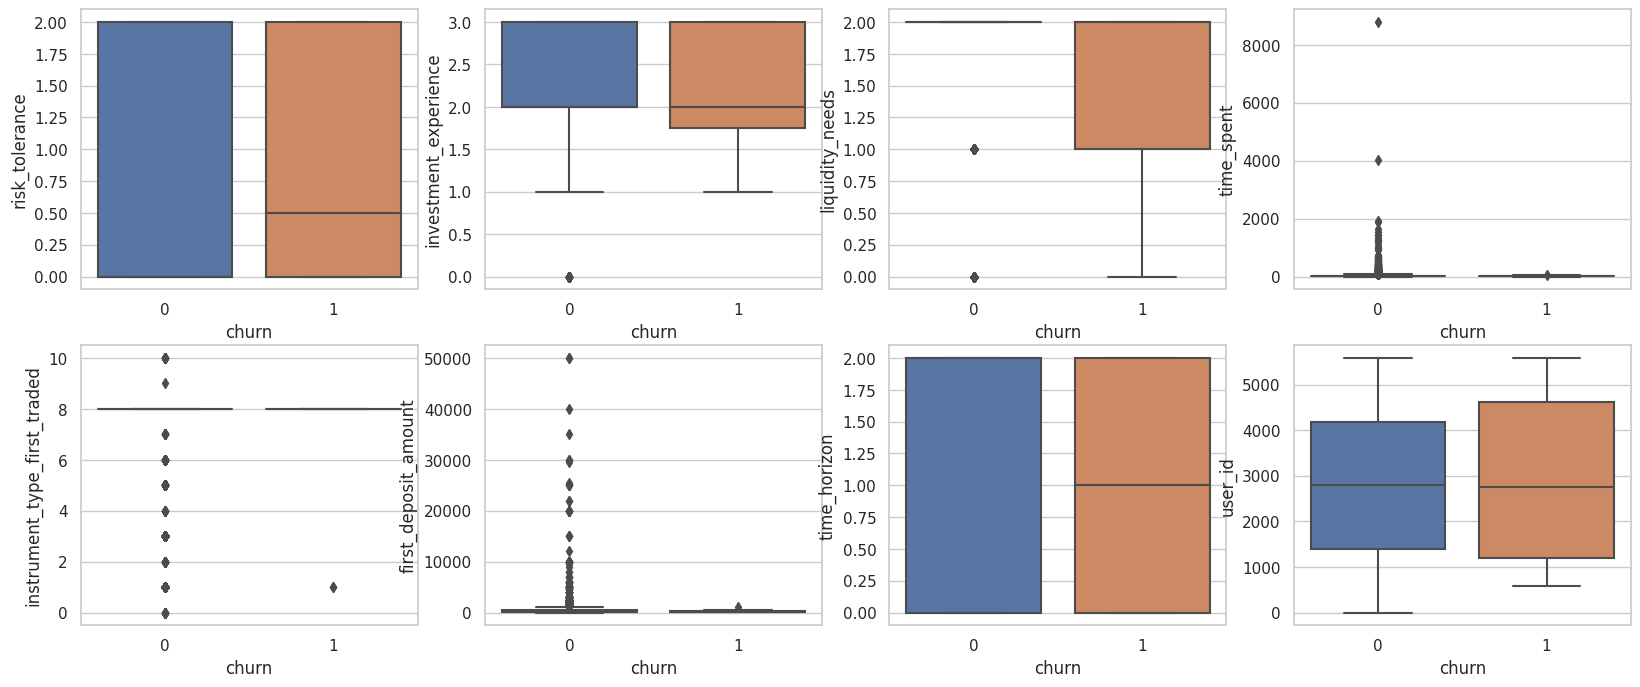

In [25]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 4, figsize = (20, 8))

count = 0
for i in range(2):
    for j in range(4):
        sns.boxplot(x = 'churn', y = model_df.columns[count], data = model_df, ax = axes[i,j])
        count += 1


In [26]:
# Finding out the fraction of churn and non-churn events in the data

In [27]:
# Percent of non-churned events
num_non_churned_users = (model_df[model_df['churn'] == 0].user_id).nunique()

percent_of_non_churned_users = (num_non_churned_users / len(total_unique_user_ids)) * 100
print(f'Percentage of Non-churn events in the data:{percent_of_non_churned_users}')


Percentage of Non-churn events in the data:2263.4146341463415


In [28]:
# Percent of churned events
num_churned_users = len(model_df[model_df['churn'] == 1])
percent_of_churned_users = (num_churned_users / len(total_unique_user_ids)) * 100
print(f'Percentage of churned events in the data:{percent_of_churned_users}')

Percentage of churned events in the data:6.504065040650407


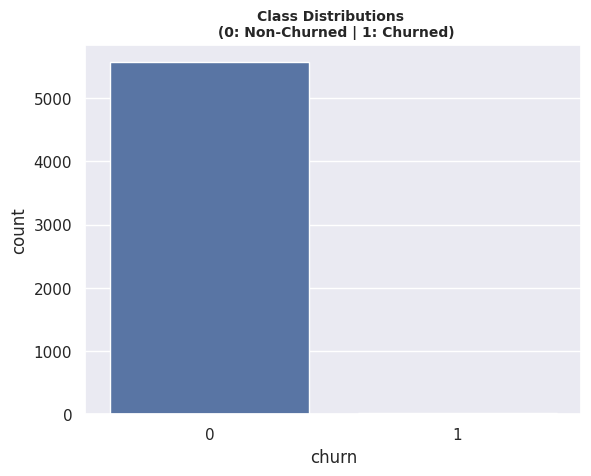

In [29]:
sns.set(style="darkgrid")
# Using Seaborn to create a bar chart to count the number of occurrences of non_churned and churned events
g = sns.countplot(data = model_df, x = 'churn')

plt.title('Class Distributions \n (0: Non-Churned | 1: Churned)', fontsize = 10, fontweight = "bold")
plt.show()

# **Scaling of Data**

# Instantiate RobustScaler() since there are outliers

In [30]:
'''
robust = RobustScaler()
# robust_features = robust.fit_transform(X)

for i in model_df.columns[:-1]:
    model_df[i] = robust.fit_transform(model_df[i].values.reshape(-1,1))

model_df.describe()
'''

'\nrobust = RobustScaler()\n# robust_features = robust.fit_transform(X)\n\nfor i in model_df.columns[:-1]:\n    model_df[i] = robust.fit_transform(model_df[i].values.reshape(-1,1))\n\nmodel_df.describe()\n'

In [31]:
# Should we plot the time_spent and first_deposit_amount? 
#sns.displot(data=model_df, x = 'time_spent')
# plt.xlim(0, 250)

#sns.displot(data=model_df, x = 'first_deposit_amount')
# plt.xlim(0, 2500)

#plt.show()

In [32]:
# Doing Chi-Square test for feature selection. 
# Splitting the data

In [33]:
X = model_df.drop(columns = ['user_id', 'churn'])
y = model_df['churn']

In [34]:
#######
# Split 80% of the data into a training set and 20% into a testing set
########
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [35]:
print(X_train.shape)
print(y_train.shape)

(4467, 10)
(4467,)


Feature 0: 0.069524
Feature 1: 0.002168
Feature 2: 0.832969
Feature 3: 90.328512
Feature 4: 0.278021
Feature 5: 3476.169206
Feature 6: 0.672406
Feature 7: 0.701075
Feature 8: 2.520745
Feature 9: 0.004001


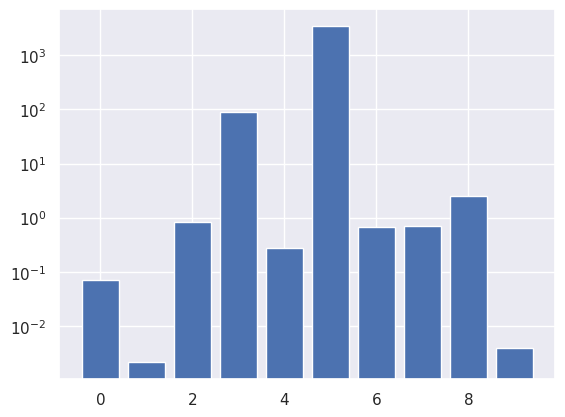

In [36]:
# Need to select features that contribute most to the target variable before moving on to modeling the data.
# Selecting scoring function to be chi2, and target number of features to be 'all'.
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func = chi2, k = 'all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# Feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# Print out the scores for the features
best_features_scores = fs.scores_
for i in range(len(best_features_scores)):
    print('Feature %d: %f' %(i, best_features_scores[i]))

# Plotting the scores. Setting the y-axis scale to be logarithmic
plt.bar([i for i in range(len(best_features_scores))], best_features_scores)
plt.yscale('log')
plt.show()


In [39]:

# You may consider creating new features such as:
#  number of churns for each user, how many days each user has been active,
#  average number of days a user churned, average equity for each user, std of equity for each user

In [44]:
# Convert model_df to datetime type
#equity_df['timestamp']= pd.to_datetime(equity_df.timestamp, errors = 'coerce')
# equity_df['timestamp'] = pd.to_datetime(equity_df['timestamp'])

# Check the datatypes
# equity_df.dtypes

# We can add some new features by extracting the day, month and year of the timestamp
#equity_df['day'] = equity_df['timestamp'].dt.day
#equity_df['month'] = equity_df['timestamp'].dt.month
#equity_df['year'] = equity_df['timestamp'].dt.year

# See that we now have new features
#equity_df.head()

# Check that everything has converted, and we don't have any nulls
# equity_df.isnull().mean()
# Yay! We do not have any nulls

In [45]:
# Creating a DataFrame, churned_users_df(different from churned_df above) that displays timestamp, close_equity, user_id, 
# month, day, year and gap_days
churned_users_df = equity_df[equity_df['gap_days'] >= pd.Timedelta('28 days')]

In [46]:
churned_users_df

,timestamp,close_equity,user_id,gap_days
7887,2017-05-15 00:00:00+00:00,4945.2200,270cda53a026bcf6c2b98492b23c1b99,73 days
8104,2017-07-27 00:00:00+00:00,20.1500,319c069e77187c7e7e7c027eb00fd941,126 days
8274,2017-07-12 00:00:00+00:00,201.8000,ec84f134c5b27c4f5702803e98eb3f40,36 days
10097,2016-12-13 00:00:00+00:00,200.0000,6dbedf7f2972b4f6ea60a15d48cb292c,60 days
11209,2017-01-27 00:00:00+00:00,277.9900,91837d41270b81b267fc205c3e03ee9b,42 days
11254,2017-05-19 00:00:00+00:00,11.7000,91837d41270b81b267fc205c3e03ee9b,49 days
11555,2017-04-13 00:00:00+00:00,100.0000,edec0a3b99769034728d37f4576a7ce9,76 days
13525,2017-07-10 00:00:00+00:00,62.4900,afb70789163c1e970a3a450046240abd,94 days
16107,2017-02-28 00:00:00+00:00,2933.4000,c162193a2274e87e36dddbc368e19be2,160 days
16395,2017-05-15 00:00:00+00:00,200.2900,42d770c7fd58e1a3c93ff190cab9cbdc,47 days


In [47]:
# Average equity per user
churned_users_df_avg_equity_per_user = churned_users_df.groupby('user_id').agg(average_equity_per_user = pd.NamedAgg(column='close_equity', aggfunc='mean'))
churned_users_df_avg_equity_per_user


,average_equity_per_user
user_id,
1a8d66727332fb16f70b0c125b462200,253.600000
270cda53a026bcf6c2b98492b23c1b99,4945.220000
2c7c1bd119f2aaf6728b1523b7b4837d,6500.065000
319c069e77187c7e7e7c027eb00fd941,20.150000
39c830063e36256f3759d48e962305f7,10.185000
42d770c7fd58e1a3c93ff190cab9cbdc,200.290000
50b846ab40078ae27b0bf7d6004c9a28,46.113333
6dbedf7f2972b4f6ea60a15d48cb292c,200.000000
91837d41270b81b267fc205c3e03ee9b,144.845000


In [48]:
# I get the above 279 rows x 1 column DataFrame. churned_users_df is a 324 rows x 7 columns DataFrame. How do I merge the 2
# DataFrames?

In [49]:
# Standard deviation for each user
churned_users_std_deviation_per_user = equity_df.groupby('user_id').agg(standard_deviation_per_user = pd.NamedAgg(column = 'close_equity', aggfunc='std'))
churned_users_std_deviation_per_user

,standard_deviation_per_user
user_id,
03674dccb53b0431c05aa24d617ca37d,189.687358
03eaef7a8cc366dc617a295a53d94eeb,524.888155
05e7e47a5d692ab5dd48ec3234fd909f,753.677156
061e27fe67bd860cccae8ea282d44534,231.781339
08260be980a7051e3db259bb1a133dd0,350.725337
...,...
f9e3f4295ec8017a75ffed3184bc9ce6,289.759932
fc7fb28490ca097e9c091f155e7dd1c5,76.860295
ff101fc228ad4497e8c2b5444df75f03,1302.292772


In [50]:
# I get a 5584 rows x 1 column DataFrame. 

In [ ]:
'''
# Should I merge model_df (which has features_df and churned_df) with equity_df? Otherwise model_df does not have 
# a 'churn' column. All the num_churned_users are in equity_df. 

# Get average number of days each user logs onto the portal
avg_days = []
avg_days_groups = equity_df.groupby('day').mean()['churn']

for val in equity_df['day']:
    avg_days.append(avg_days_groups.loc[val])
'''

Accuracy of X_test (in %):  99.73142345568488
F1 score:  0.0
AUC Score = 0.4528725314183124


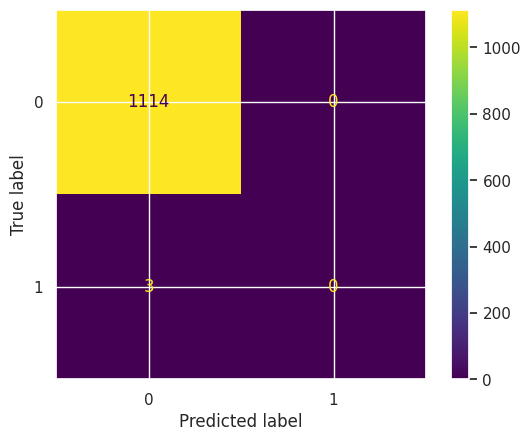

In [51]:
##############
# Create and train using Random Forest Classifier
##############
rf_clf = RandomForestClassifier(n_estimators = 100)
rf_clf = rf_clf.fit(X_train, y_train)

# Compute the mean accuracy using the test set(X_test, y_test)
mean_accuracy = rf_clf.score(X_test, y_test) * 100
print('Accuracy of X_test (in %): ', mean_accuracy)

y_pred = rf_clf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print('F1 score: ', f1)

# Run the confusion matrix function on actual and predicted label values.
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot()

# predict_proba() gives the probability of the feature belonging to each output class
roc_auc = roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])
print('AUC Score =', roc_auc)

In [52]:
# We have good accuracy here. But the F1-score (<0.5) means this classifier gives a high number of false positives (which 
# we can see from the confusion matrix above as well. This could be the outcome of an imbalanced class. The ROC_AUC score 
# tells us how efficient the model is. The higher the ROC_AUC score is, the better the model's performance is at distinguishing
# between the positive and negative classes. We achieved 0.4425 which means the classifier is doing a moderate job in distinguishing
# the positive and negative classes. 


[0.05786675 0.04690002 0.02481269 0.60818297 0.02788146 0.16187833
 0.04515779 0.00777673 0.0092768  0.01026647]


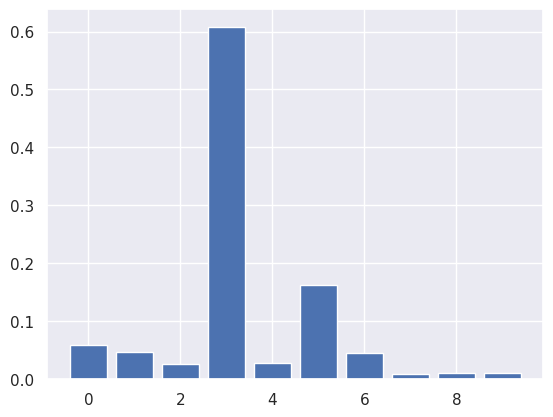

In [53]:
##########
# Checking the feature importance of the random forest classifier
##########
importance = rf_clf.feature_importances_
print(importance)

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [54]:
# Balancing the imbalanced classes by under-sampling. Refer to
# https://goldinlocks.github.io/Imbalanced-Classes/

churned_df = model_df[model_df['churn'] == 1]
churned_df_len = len(churned_df)

non_churned_df = model_df[model_df['churn'] == 0][:churned_df_len]

non_churned_df_len = len(non_churned_df)

# Shuffle the non-churned and churned users via scikit-learn 

# Create a balanced DataFrame by concatenating non_churned_df and churned_df
balanced_df = pd.concat([churned_df, non_churned_df])

# Returning (100%) random sample (essentially shuffling) from this balanced_df
shuffled_from_balanced_df = balanced_df.sample(frac=1, random_state=None)
shuffled_from_balanced_df.head()

,risk_tolerance,investment_experience,liquidity_needs,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn,platform_Android,platform_both,platform_iOS
2,2.0,2.0,2.0,10.008367,8.0,25.0,0.0,4326.0,0,0,0,1
3,2.0,2.0,2.0,1.031633,8.0,100.0,2.0,3854.0,0,1,0,0
5462,2.0,3.0,1.0,11.817950,8.0,25.0,2.0,5161.0,1,0,0,1
1354,0.0,1.0,1.0,11.368333,8.0,250.0,0.0,3809.0,1,0,0,1
1,2.0,2.0,2.0,16.573517,8.0,200.0,2.0,1512.0,0,1,0,0


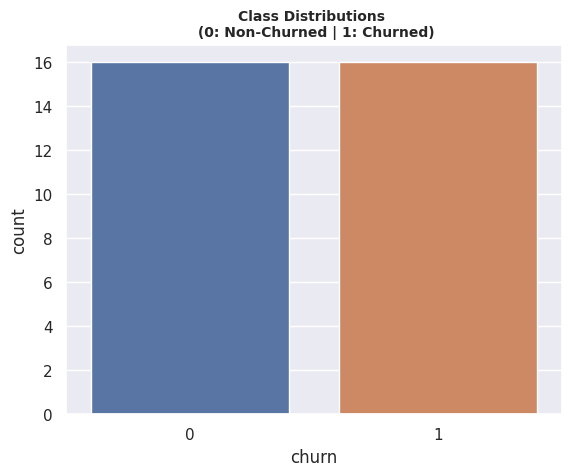

In [55]:
# Let's see how the class distribution looks now
sns.set(style="darkgrid")
sns.countplot(data=shuffled_from_balanced_df, x = 'churn')
plt.title('Class Distributions \n (0: Non-Churned | 1: Churned)', fontsize = 10, fontweight ="bold")
plt.show()

In [56]:
# Removing columns 'user_id' and 'churn' from shuffled_from_balanced_df
X = shuffled_from_balanced_df.drop(columns = ['user_id', 'churn'], axis = 1)
# The label consists of values from the 'churn' column
y = shuffled_from_balanced_df['churn']

In [57]:
shuffled_from_balanced_df


,risk_tolerance,investment_experience,liquidity_needs,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn,platform_Android,platform_both,platform_iOS
2,2.0,2.0,2.0,10.008367,8.0,25.0,0.0,4326.0,0,0,0,1
3,2.0,2.0,2.0,1.031633,8.0,100.0,2.0,3854.0,0,1,0,0
5462,2.0,3.0,1.0,11.817950,8.0,25.0,2.0,5161.0,1,0,0,1
1354,0.0,1.0,1.0,11.368333,8.0,250.0,0.0,3809.0,1,0,0,1
1,2.0,2.0,2.0,16.573517,8.0,200.0,2.0,1512.0,0,1,0,0
15,0.0,3.0,2.0,4.553017,10.0,10.0,1.0,133.0,0,0,0,1
8,0.0,1.0,2.0,0.000000,8.0,5000.0,2.0,2884.0,0,0,0,1
2124,0.0,2.0,2.0,11.571100,8.0,25.0,0.0,1076.0,1,0,0,1
4659,0.0,1.0,2.0,48.930517,8.0,50.0,0.0,2375.0,1,0,0,1
2818,2.0,3.0,2.0,15.726483,8.0,10.0,2.0,5197.0,1,1,0,0


In [58]:
shuffled_from_balanced_df.shape


(32, 12)

In [59]:
########
# Split 75% of the data into a training set and 25% into a testing set
########
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24, 10)
(8, 10)
(24,)
(8,)


Feature 0: 0.416236
Feature 1: 0.067692
Feature 2: 0.716084
Feature 3: 15.402691
Feature 4: 0.023976
Feature 5: 11209.636390
Feature 6: 0.282051
Feature 7: 1.573427
Feature 8: 2.538462
Feature 9: 0.083916


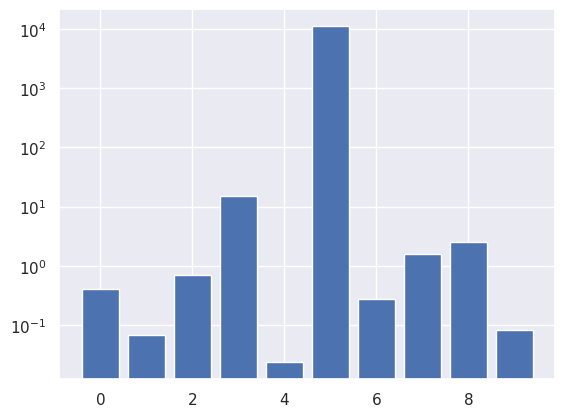

In [60]:
# Feature selection from this shufffled_from_balanced_df
def select_features_2(X_train, y_train, X_test):
    fs_shuffled_from_balanced_df = SelectKBest(score_func = chi2, k = 'all')
    fs_shuffled_from_balanced_df.fit(X_train, y_train)
    X_train_fs = fs_shuffled_from_balanced_df.transform(X_train)
    X_test_fs = fs_shuffled_from_balanced_df.transform(X_test)
    return X_train_fs, X_test_fs, fs_shuffled_from_balanced_df

X_train_fs, X_test_fs, fs_shuffled_from_balanced_df = select_features_2(X_train, y_train, X_test)

best_features_scores = fs_shuffled_from_balanced_df.scores_
for i in range(len(best_features_scores)):
  print('Feature %d: %f' % (i, best_features_scores[i]))

# Plotting the scores
plt.bar([i for i in range(len(best_features_scores))], best_features_scores)
plt.yscale('log')
plt.show()

Accuracy of X_test (in %):  75.0
F1 score:  0.7499999999999999
AUC Score = 0.7333333333333333


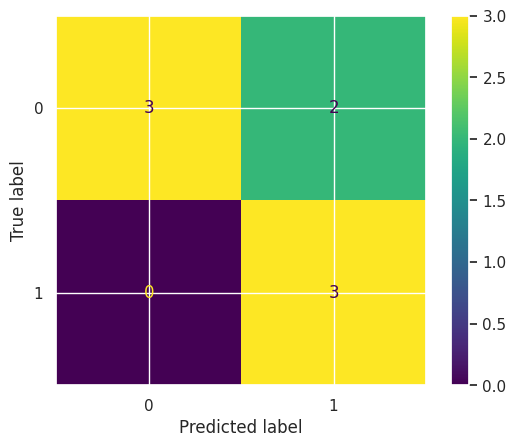

In [61]:
# Run the random forest classifier again on this new set of data shuffled from balanced_df and examine the feature_importance,
# precision, f1-score and recall. Are they improving?

rf_clf = RandomForestClassifier(n_estimators = 300)
rf_clf.fit(X_train, y_train)

# Compute the mean accuracy of the test set (X_test, y_test)
mean_accuracy_2 = rf_clf.score(X_test, y_test) * 100
print('Accuracy of X_test (in %): ', mean_accuracy_2)

y_pred = rf_clf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print('F1 score: ', f1)

# Run the confusion matrix function on actual and predicted label values.
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot()

# predict_proba() gives the probability of the feature belonging to each output class
roc_auc = roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])
print('AUC Score =', roc_auc)

[0.06105568 0.06183208 0.07119675 0.32445712 0.02991592 0.21879666
 0.07843127 0.07433167 0.05025316 0.0297297 ]


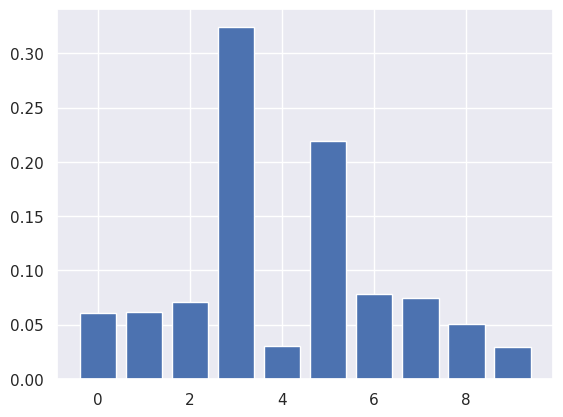

In [62]:
##############
# Checking the feature importance
###############
feat_importance = rf_clf.feature_importances_
print(feat_importance)
plt.bar([i for i in range(len(feat_importance))], feat_importance)
plt.show()

In [63]:
# The ROC_AUC score (0.57536)  is now not much better than before (0.588875). F1-score seems to be pointing that we now
# have higher number of false positives. So, under-sampling has not improved the efficiency of the model. 

In [64]:
# Let us use SMOTE (Synthetic Minority Over-sampling Technique) to create synthetic samples from the minority class
# instead of creating copies. 

In [65]:
# Reloading imbalanced Dataframe, model_df for over
X = model_df.drop(columns = ['user_id', 'churn'])
y = model_df['churn']

######################
# Splitting the data into 80% training set and 20% testing set
######################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(X_test.shape)

# Define the over-sampling method
oversample = SMOTE()

# Transform the dataset
# X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# Transform the X_train dataset
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape)

(4467, 10)
(1117, 10)
(8908, 10)


In [66]:
print(X_test.shape)

(1117, 10)


Feature 0 5.301055
Feature 1 0.355759
Feature 2 121.219450
Feature 3 20320.539404
Feature 4 65.326453
Feature 5 1174675.910354
Feature 6 170.439943
Feature 7 900.159527
Feature 8 147.879713
Feature 9 232.843026


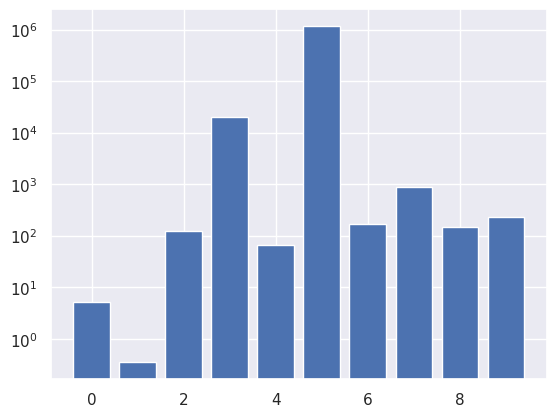

In [67]:
###########################################
# Now, after over-sampling , we need to run chi-squared feature selection and random forest
# classifier again on this over-sampled dataset. We will then evaluate the feature_importance,
# AUC score, confusion_matrix, precision and recall.
############################################
def select_features_3(X_train, y_train, X_test):
    fs_oversampled = SelectKBest(score_func = chi2, k = 'all')
    fs_oversampled.fit(X_train, y_train)
    X_train_fs = fs_oversampled.transform(X_train)
    X_test_fs = fs_oversampled.transform(X_test)
    return X_train_fs, X_test_fs, fs_oversampled

X_train_fs, X_test_fs, fs_oversampled = select_features_3(X_train, y_train, X_test)

# Obtaining the scores for the features
best_features_scores = fs_oversampled.scores_
for i in range(len(best_features_scores)):
    print('Feature %d %f' %(i, best_features_scores[i]))

# Plotting the scores
plt.bar([i for i in range(len(best_features_scores))], best_features_scores)
plt.yscale('log')
plt.show()

In [68]:
# Running the random forest classifier on this over-sampled dataset and examine the feature_importance, AUC score, confusion_matrix,
# precision and recall. Are they improving?
rf_clf = RandomForestClassifier(n_estimators = 200)
rf_clf = rf_clf.fit(X_train, y_train)

# Calculate the mean_accuracy
mean_accuracy_3 = rf_clf.score(X_test, y_test) * 100
print('Accuracy of X_test (in %): ', mean_accuracy_3)

y_pred = rf_clf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print('F1 score: ', f1)


Accuracy of X_test (in %):  99.73142345568488
F1 score:  0.0


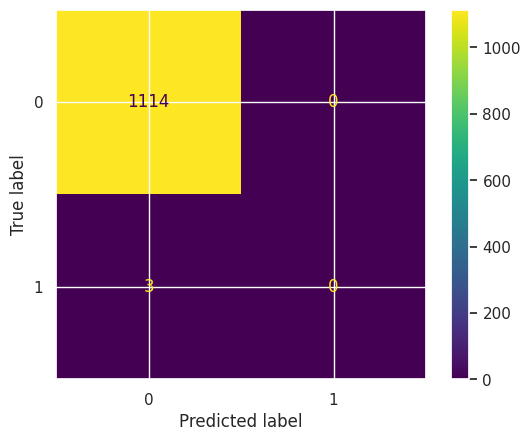

In [69]:
# Run the confusion matrix function on actual and predicted label values.
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot()

In [70]:
# predict_proba() gives the probability of the feature belonging to each output class
roc_auc = roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])
print('AUC Score =', roc_auc)

AUC Score = 0.4111310592459605


[0.20133492 0.10581595 0.05381597 0.13308088 0.01672005 0.12786223
 0.19007976 0.08058823 0.02115461 0.0695474 ]


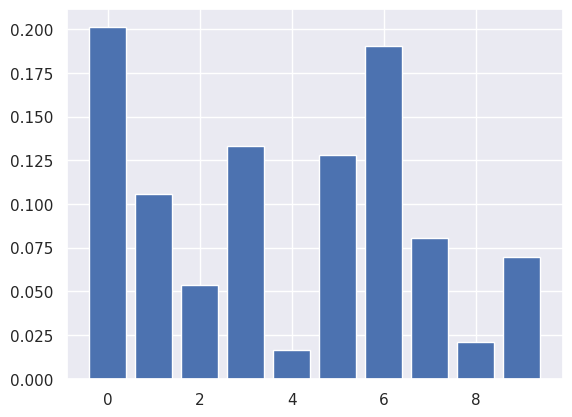

In [71]:
##############
# Checking the feature importance
###############
feat_importance = rf_clf.feature_importances_
print(feat_importance)
plt.bar([i for i in range(len(feat_importance))], feat_importance)
plt.show()

In [72]:
# From the above exercise with Over-sampling, it appears that Feature 2 - liquidity_needs and Feature 5 - instrument_type_first_traded
# are not that important. Let us drop those 2 columns

new_model_df = model_df.drop(['liquidity_needs','instrument_type_first_traded'], axis=1)
new_model_df.describe(percentiles=[.25, .50, .75, .90, .95, .99])

,risk_tolerance,investment_experience,time_spent,first_deposit_amount,time_horizon,user_id,churn,platform_Android,platform_both,platform_iOS
count,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000
mean,0.679979,2.091332,34.509706,633.566805,1.179083,2791.500000,0.002865,0.273818,0.090437,0.635745
std,0.924629,0.755589,155.080551,2118.323263,0.896479,1612.106283,0.053457,0.445957,0.286832,0.481264
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,2.848908,50.000000,0.000000,1395.750000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,13.474708,100.000000,2.000000,2791.500000,0.000000,0.000000,0.000000,1.000000
75%,2.000000,3.000000,33.823829,500.000000,2.000000,4187.250000,0.000000,1.000000,0.000000,1.000000
90%,2.000000,3.000000,68.428915,1000.000000,2.000000,5024.700000,0.000000,1.000000,0.000000,1.000000
95%,2.000000,3.000000,106.278442,2500.000000,2.000000,5303.850000,0.000000,1.000000,1.000000,1.000000
99%,2.000000,3.000000,310.200421,8000.000000,2.000000,5527.170000,0.000000,1.000000,1.000000,1.000000


In [73]:
new_model_df.groupby('risk_tolerance').agg({'churn': ['mean', 'count']})

churn      
                    mean count
risk_tolerance                
0.0             0.002243  3566
1.0             0.008368   239
2.0             0.003373  1779